<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4206_202410_AML/blob/main/Talleres/Taller%204/Taller%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

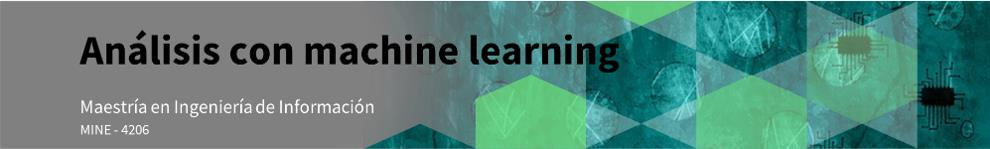

- **Integrante 1:** Lina María Gómez Mesa
- **Integrante 2:** María Catalina Ibáñez Piñeres

# Contexto y objetivos.

### **Generación de paleta de colores a partir de imágenes con técnicas de machine learning no supervisado**

Una paleta de colores es un conjunto de tonos que se utilizan juntos para crear un efecto armonioso, coherente y atractivo en las representaciones visuales (diseño gráfico, cine, fotografía, pintura, etc.), así como para transmitir mensajes y generar emociones determinados, de acuerdo con la intencionalidad del autor de la obra.    

En un contexto de amplia demanda de herramientas que puedan asistir a diseñadores gráficos, directores de arte, pintores y creadores de contenido, entre otros, para la selección rápida y adecuada de los colores apropiados para sus obras, una aplicación para configurar paletas de colores a partir de imágenes sería de mucha utilidad.  

Una vía para lograr una herramienta como esta es utilizar técnicas de machine learning no supervisado sobre imágenes para visualizar la distribución de los colores presentes en estas y generar, de manera automática, modelos de paletas de colores. En esta primera aproximación el método va a permitir identificar los colores en una imagen para construir un muestrario por similitud de píxeles, lo cual puede ser muy útil para estudios de marketing, psicología, medicina, arte, ambiente, entre otros. Por ejemplo, se podrían extraer los colores de las diferentes superficies de la Tierra en una imagen satelital para estudiar la distribución de la vegetación o de la contaminación.

Los datos están asociados con imágenes de obras de arte. Pueden ser descargados a partir de este [enlace](https://www.kaggle.com/datasets/steubk/wikiart).  

# Actividades a realizar

1. Recopilación de las imágenes a partir del repositorio. La idea es seleccionar un conjunto diverso de muestras en diferentes estilos artísticos (no más de 10).

2. Preparación de las imágenes para el entrenamiento y prueba del modelo. Para este paso construir un pipeline que integre las transformaciones que se consideren adecuadas.

3. Desarrollo del modelo de agrupación para identificar los colores presentes en las imágenes.

4. Creación de un modelo que transforme los grupos de colores identificados en un muestrario representativo. Adicionalmente, se debe mostrar la distribución de los colores de la imagen en un espacio de dos dimensiones utilizando t-SNE.

**NOTA**: La calificación será sobre notebook ejecutado.

### **Consideraciones:**
- El algoritmo de agrupación a utilizar queda a consideración de cada grupo, pero es importante justificar la elección.

- Se debe evidenciar el desempeño del método construido mostrando la paleta para al menos cuatro (4) imágenes de diferentes estilos, con la visualización de la distribución de colores en el espacio de dos dimensiones.

- Un diagrama general del método que se quiere desarrollar se muestra en la siguiente figura:


# 0. Importar librerías

In [16]:
import pandas as pd
import numpy as np
import os
import os.path as osp
import pandas as pd
import requests
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import pandas as pd



import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

pd.set_option('display.max_colwidth', None)

## Punto 1: Recopilación de Imágenes

In [17]:
img_classes = pd.read_csv("Data/classes.csv")

sample_10 = pd.read_csv("Data/sample_10.csv", header=None)
lista = sample_10[0].unique()
img_selected = []
diccio = {}
for img in range(len(lista)):
    url =lista[img].split("4202543/")[1].split("?X-Goog-Algorithm")[0]
    img_selected.append(url)
    diccio[url] = lista[img][1:-1]
img_selected

['Contemporary_Realism/lucian-freud_factory-in-north-london.jpg',
 'Early_Renaissance/filippo-lippi_disputation-in-the-synagogue-detail-1465.jpg',
 'Impressionism/armand-guillaumin_moulins-en-hollandee-1904.jpg',
 'Cubism/albert-gleizes_untitled-3.jpg',
 'Naive_Art_Primitivism/andre-bauchant_le-bouquet-1928.jpg',
 'Northern_Renaissance/albrecht-altdorfer_the-battle-of-issus-1529.jpg',
 'Pop_Art/aldo-mondino_collage-1973.jpg',
 'Symbolism/a.y.-jackson_smart-river-alaska-1945.jpg',
 'Fauvism/andre-derain_figures-from-a-carnival.jpg',
 'Art_Nouveau_Modern/aladar-korosfoi-kriesch_lady-with-tiara.jpg']

In [18]:
filtered_img_classes = img_classes[img_classes['filename'].isin(img_selected)]
filtered_img_classes

,filename,artist,genre,description,phash,width,height,genre_count,subset
2262,Art_Nouveau_Modern/aladar-korosfoi-kriesch_lady-with-tiara.jpg,aladar korosfoi kriesch,['Art Nouveau Modern'],lady-with-tiara,cc2bb3d64c799039,1382,1740,1,train
10485,Contemporary_Realism/lucian-freud_factory-in-north-london.jpg,lucian freud,['Contemporary Realism'],factory-in-north-london,ddc75638863a2ac6,1394,1382,1,train
10622,Cubism/albert-gleizes_untitled-3.jpg,albert gleizes,['Cubism'],untitled-3,cfb63198ce649893,1936,1382,1,train
12821,Early_Renaissance/filippo-lippi_disputation-in-the-synagogue-detail-1465.jpg,filippo lippi,['Early Renaissance'],disputation-in-the-synagogue-detail-1465,81367edb17564c4a,1382,1921,1,train
18528,Fauvism/andre-derain_figures-from-a-carnival.jpg,andre derain,['Fauvism'],figures-from-a-carnival,b08bcd2083f2decd,1897,1382,1,train
21099,Impressionism/armand-guillaumin_moulins-en-hollandee-1904.jpg,armand guillaumin,['Impressionism'],moulins-en-hollandee-1904,9ef2e00149ff0f31,1718,1382,1,train
32815,Naive_Art_Primitivism/andre-bauchant_le-bouquet-1928.jpg,andre bauchant,['Naive Art Primitivism'],le-bouquet-1928,c296591b37643ccb,1382,1658,1,train
34999,Northern_Renaissance/albrecht-altdorfer_the-battle-of-issus-1529.jpg,albrecht altdorfer,['Northern Renaissance'],the-battle-of-issus-1529,9d8cc47c2c8cea4f,1382,1784,1,train
59251,Symbolism/a.y.-jackson_smart-river-alaska-1945.jpg,a.y. jackson,"['Symbolism', 'Art Nouveau Modern']",smart-river-alaska-1945,d23fa9a0d78f0d28,1877,1382,2,train
73379,Pop_Art/aldo-mondino_collage-1973.jpg,aldo mondino,['Pop Art'],collage-1973,ba23c43f93c4f8c2,1382,1742,1,test


In [19]:
filtered_img_classes.loc[:, 'url'] = filtered_img_classes['filename'].map(diccio)

C:\Users\lgome\AppData\Local\Temp\ipykernel_34884\4201899911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_img_classes.loc[:, 'url'] = filtered_img_classes['filename'].map(diccio)


In [7]:
def download_image(url, filename):
    response = requests.get(url)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        f.write(response.content)

for index, row in filtered_img_classes.iterrows():
    url = row['url']
    filename = row['filename']
    download_image(url, filename)

In [20]:
from PIL import Image

def load_image(filename):
    try:
        img = Image.open(filename)
        img = img.convert("RGB")
        return img
    except FileNotFoundError:
        return None

filtered_img_classes.loc[:, 'image'] = filtered_img_classes['filename'].apply(load_image)

C:\Users\lgome\AppData\Local\Temp\ipykernel_34884\4036918011.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_img_classes.loc[:, 'image'] = filtered_img_classes['filename'].apply(load_image)


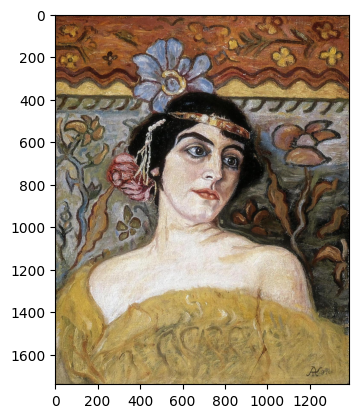

In [21]:
import matplotlib.pyplot as plt

image = filtered_img_classes["image"].iloc[0]
plt.imshow(image)
plt.show()

## Punto 2: Preparación de imágenes para la prueba del modelo

In [22]:
from skimage import io, color, transform

def preprocess_image(image_path):
    downsample_factor = 0.1
    image = io.imread(image_path)

    if image.shape[-1] == 4:
        image = color.rgba2rgb(image)

    image_downsampled = transform.rescale(image, downsample_factor)

    X = image_downsampled.reshape(-1, image.shape[-1])

    return X

In [23]:
filtered_img_classes.loc[:, 'image_post']= filtered_img_classes['filename'].apply(preprocess_image)

C:\Users\lgome\AppData\Local\Temp\ipykernel_34884\3185759369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_img_classes.loc[:, 'image_post']= filtered_img_classes['filename'].apply(preprocess_image)


## Punto 3: Desarrollo del modelo de agrupación para identificar los colores presentes en las imágenes

In [25]:
def silhouette_plot_from_image(X, art, k_min=2, k_max=5, linkage='ward'):
    """
    Generate silhouette plot for clustering on an image.

    Parameters:
    image_path : str
        Path to the image file.
    k_min : int
        Minimum value for k.
    k_max : int
        Maximum value for k.
    linkage : str
        Linkage criterion. Parameter for AgglomerativeClustering().
    downsample_factor : float
        Factor by which to downsample the image. Should be between 0 and 1.
    """
    
    # Calculate silhouette scores for different values of k
    scores = []
    for i in range(k_min, k_max+1):
        model_k = AgglomerativeClustering(n_clusters=i, linkage=linkage)
        # Train the model
        model_k.fit(X)
        # Store the silhouette score
        score = silhouette_score(X, model_k.labels_)
        scores.append(score)

    plt.plot(range(k_min, k_max+1), scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.suptilte(f'Silhouette Score vs. Number of Clusters for {art}')
    plt.grid()
    plt.show()




In [26]:
for index, row in filtered_img_classes.iterrows():
    image = row['image_post']
    artist = row['artist']
    silhouette_plot_from_image(image, k_min=2, k_max=5,art= artist)